In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import transform_helper

sph = transform_helper.StockReturn_Pooling_Helper()

# Create plots for Fundamental Assumption
ssm = transform_helper.StockPrice_shiftedMean_Helper()
ss_df = ssm.gen_prices(.001, .02, [10, 20], num_returns=252)
fig_data, axs_data = ssm.plot_data(ss_df, visible=False)
fig_segs, axs_segs = ssm.plot_segments(ss_df, visible=False)

sdrift = transform_helper.StockPrice_drift_Helper()
sdrift_df = sdrift.gen_prices(.000, .01, drift=.0015, level_init=10, num_returns=504)

fig_sdrift, axs_sdrift = sdrift.plot_data(sdrift_df, visible=False)
fig_sdrift_mean, axs_sdrift_mean = sdrift.plot_rolling(sdrift_df, window=30, visible=False)

# Create plots for shifted price
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig_sp, ax_sp = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax_sp)

plt.close(fig_sp)

# Create plots for relative price
rph = transform_helper.RelativePrice_Helper()
series = rph.gen_data(attrs=["area", "price"])

labels=[ "USD", "USD", "RMB", "HKD" ]

fig_rp, ax_rp = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series, ax=ax_rp, labels=labels, xlabel="Area", ylabel="Price (local)")

plt.close(fig_rp)

In [4]:
# Geron Housing Data example
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

# Data science in practice

Being a successful Data Scientist is much more than just knowing models.

Being able to gather, join, and clean Data is a prerequisite to being able to train a model.
- the remarkable success of Large Language Models (e.g., ChatGPT) is in large part due to vast quantities of carefully curated data

*Manipulating and transforming* the Data into a form in which a successful model can be built
is a skill that may not be truly appreciated.
- data is frequently transformed from its raw form to synthesized features and targets
- the relationship between features and target may not be present in raw form

It is this latter skill that we now focus on.

# Transforming features to make them more predictive

## Example: Titanic Survival synthetic features

Recall that our Exploratory Data Analysis of the Titanic Survival problem
- suggested the need to create some *synthetic* features
- as *transformations* of the raw features

This process is called *Feature Engineering*.

One form of feature engineering that was suggested by Titanic Survival
- creating *compound* synthetic features as the intersection of other features

$$
\text{IsFemale}  \; \mathbf{ and } \; \neg \text{IsThirdClass}
$$

Another type of synthetic feature suggested was creating binary *indicator* variables
- as a way of encoding *categorical* values
$$\text{Pclass}= \{ \text{First}, \text{Second}, \text{Third} \}$$
rather than
$$\text{PClass} = \{ 1, 2, 3 \}$$
using synthetic binary features
$$\text{IsFirstClass}, \,\text{IsSecondClass}, \, \text{IsThirdClass}$$
- turning a continuous variable into a categorical
    - bucketing Ages
    
    using synthetic binary features
    
$$\text{IsAge0-15}, \, \text{IsAge15-30},  \, \ldots $$

## Example: predicting house prices (Geron)

**Attribution**

There is a more realistic exercise in predicting house prices than the overly-simplistic
version we presented in our initial lectures.

I highly recommend this notebook to see a more detailed use of the Recipe for Machine Learning.

The referenced [notebook](02_end_to_end_machine_learning_project.ipynb)
is derived from:
- version two of book by Aurelien Geron, [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- There is a later version of this book (Version 3 in year 2022)
 - can't verify that this example is still present

We are trying to predict house prices (actually: the median price within a geographic area).

There are many [attributes available](02_end_to_end_machine_learning_project.ipynb#Take-a-Quick-Look-at-the-Data-Structure).

We focus on
- `total_rooms`
- `total_bedrooms`

When we perform the "Examine the Data"
- we recognize that the units are

    `total number of rooms within the geographic area`

Because 
- a geographic area with a larger population
- is likely to have a large number of rooms

these units may not be predictive of housing price.

It would be better to
- normalize these values
- to compensate for differences in population


The attributes available as potential normalizers are
- `population`
- `households`

The latter (`households`) may be preferred
- members of the same household cohabit
- so demand for housing is probably more related to the number of households

Hence, we may create synthetic features such as

- `total_rooms`/`households`
- `total_bedrooms`/`households`

to *replace* the raw features `total_rooms`, `total_bedrooms`.

We should examine whether there is a stronger predictive value
- in the normalized features
- compared to the raw features

## Example: predicting financial distress

Suppose our examples
- index over companies
    - $\x^\ip$ and $\x^{(\mathbf{i'})}$ are the features of two different companies
    
Furthermore, let feature $j$ be the amount of debt owed by a company.

Suppose companies $i$ and $i'$ have a nearly identical amount of debt
$$
\x^\ip_j \approx \x^{(\mathbf{i'})}_j
$$

Are they equally-likely to experience financial distress, e.g., default ?

To make the answer clearer
- assume company $i$ is 10 times as large as company $i'$
    - in assets
    - in income (ability to service debt)
    
It is probably the case that company $i$ is better able to service the debt.

Thus, the *level* of feature $j$ (debt) is unlikely to be predictive of financial distress.

A better metric would be a *synthetic featurue* that relativized the debt
- to the size of the company
$$\frac{\text{debt}}{\text{assets}}$$
- to the ability to service it
$$\frac{\text{debt}}{\text{income}}$$

## **Example: modeling prepayments**

We use plots from the following [notebook](Mortgage_Incentive_plots.ipynb) to illustrate.

**Synthetic variable: incentive to prepay**

Consider the following example.

Suppose our goal is to predict whether a borrower will prepay a mortgage.  

As raw features: we have variables
- Interest rate (coupon) $C$ on borrower's loan
- Rate $r$ at a which a mortgage could be re-financed

The borrower has an incentive to prepay if $C > r$.
- there are many other reasons for pre-payment
- we focus here only on reasons caused by changing interest rates

For example:

Suppose $C = 5 \%$
- when the refinance rate $r > 5 \%$: no incentive
- when the refinance rate $r < 5 \%$: positive incentive

See the first two figures in the notebook.

Consider a different approach to modeling:
- we use a *synthetic* feature $I$  capturing *incentive* to prepay
- rather than just raw values $C, r$ for borrower's current rate and contemporaneous re-finance rate

For example, we could create feature $I$ in several possible ways
- $I = \max{}(0, C-r)$
    - incentive denominated in Percentage Points
- $I = \max{}(0, \frac{C}{r} -1)$
    - incentive denominated as relative to re-finance rate

See the third figure in the notebook.

The synthetic feature $I$ is much more likely to be correlated with the target.

Hence, a transformation from $C$ and $r$ to $I$ is more likely to result in a model with good predictions.

**Incentive facilitates processing of rare events**

But there is *another* reason to use $I$

Suppose the current level of $r$ (test time) is at an extreme value versus history (training data)
- $r \lt \min{\x^\ip \in \X }{ \x^\ip_r }$ or $r \gt \min{\x^\ip \in \X }{ \x^\ip_r }$
- your trained model must *extrapolate* beyond the examples on which it was trained
    - the form of extrapolation depends on the model's functional form

Our out of sample examples would not be from the same distribution as the training examples !


Even if the current level of $r$ is rare in history (but not at an extreme)
- so could be from the same distribution as training
- we have few training examples on which to base the prediction when using $r$ as the feature

Synthetic $I$ is more likely to avert both issues
- there are many historical examples $i$ where features $\x_r^\ip, C^\ip$ having the same  Incentive $I$

For example, $I =  \max{}(0, C-r) = 1 \%$ occurs when

- $\x_r^\ip = 3\%, \, C^\ip = 4\%$ re-finance rate extremely low
- $\x_r^\ip = 8\%, \, C^\ip = 9\%$ re-finance rate extremely high
- $\x_r^\ip = 5\%, \, C^\ip = 6 \%$ 

See the fourth figure in the notebook.

**Incentive feature facilitates pooling of historical data**

Using the synthetic feature opens up the possibility of using a lot more historical data
- Many more historical episodes with a particular value of $\frac{C}{r}$ or $C-r$
- Compared to examples where the then-current re-finance rate equals today's rate $r$

Another advantage: It allows the model
- to work for examples with a range of values for $I$
- rather than the immediate need of examples where $r \approx r'$

In essence, re-denomination into Incentive $I$
- has allowed us to pool examples
    - over time
    - over different levels of re-finance rate

# Transforming features to facilitate Pooling of examples

Recall the Fundamental Assumption of Machine Learning

- That each training and test example $(\x, \y)$ 
- is a sample drawn from $\pdata$
- where $\pdata$ is the true (but unknown) distribution of examples


It is surprisingly easy to violate this assumption

Consider the timeseries of prices of an equity

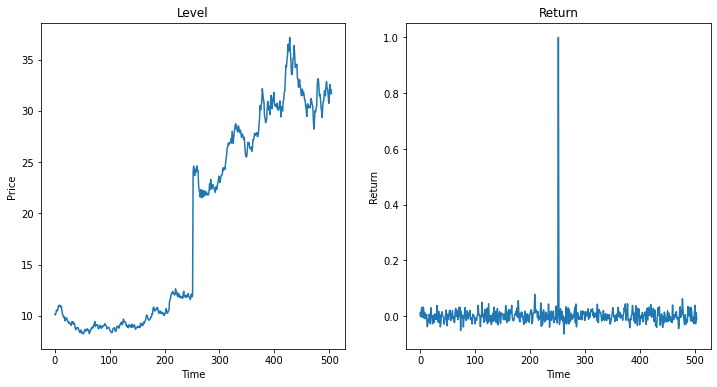

In [7]:
fig_data

One can easily see that there are two distributions here
- a low-mean (and low variance) distribution prior to the jump in Price
- a high-mean (and high variance) distribution after the jump

The test data (drawn post jump) is **not** from the same distribution as the training data (pre-jump).

In fact: if the training data also includes examples post-jump
- it would seem that the training data comes from the union of *two different* distributions

At first glance, this seems surprising.

After all, each Price is drawn from the distribution of a single equity.

But, as is very typical in Finance, our distributions *vary with time*.

A more common example:

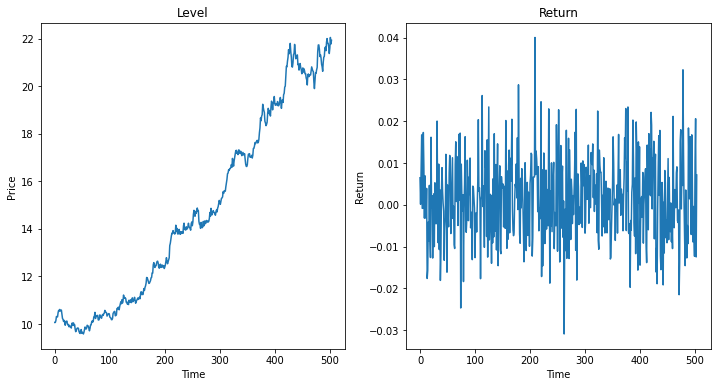

In [8]:
fig_sdrift

So, in order to satisfy the Assumption
- we typically transform the Price distribution into a Return distribution
- which is often (but not always) more stable over time

# The Power of Pooling

Converting price levels into percent price changes
- allows us to combine distributions
    - low price level and high price level
    
Similarly, creating the Mortgage Prepayment Incentive feature
- allows us to combine examples over multiple time periods
    - where levels of rates are much different
 
Combining examples from multiple distributions is called *Pooling*.

It is a key method for
- "stretching" the supply of training examples
- that are similar in distribution to the expected out-of-sample distribution

Pooling increases the size of the training dataset and can result in better models
- more diverse examples
    - better representative of out-of-sample
- increased statistical support

**This is particularly valuable in Finance**
- where sample sizes can be small
- because observations occur at low frequency (daily)

   


We illustrate the need for diverse data.

Recall our Linear Regression example.
- **See the plot in [Price as a function of Size](Recipe_via_Linear_Regression.ipynb#Error-Analysis)**
- Had our training examples **not** included extreme values of Size
    - it would be easy to mis-fit a linear function
    - rather than the true second-order polynomial

We can see this too via the [plots](Recipe_Training_data.ipynb#Fundamental-assumption-of-Machine-Learning).
- the true function mapping features to target is a *complex* surface
- a narrow slice of the surface enables us to fit *an incorrect function*
    - correct only for the narrow slice
    - incorrect for out-of-sample relative to the narrow slice

We call the process that enables pooling
- a way to transform a non-homogeneous distribution of a raw feature
- into a homogeneous distribution of a synthetic feature

We will imagine that
- the available data comes from one or more *groups* each with its own distribution.
- we will transform the data so that they appear to come from a single common group

**Example: Pooling over time**

Let's go back to our original Regression problem
- predicting Price of an apartment from its Size

Consider the following graph illustrating the relationship between Price (target) and Size (features)
- measured at two distinct time periods

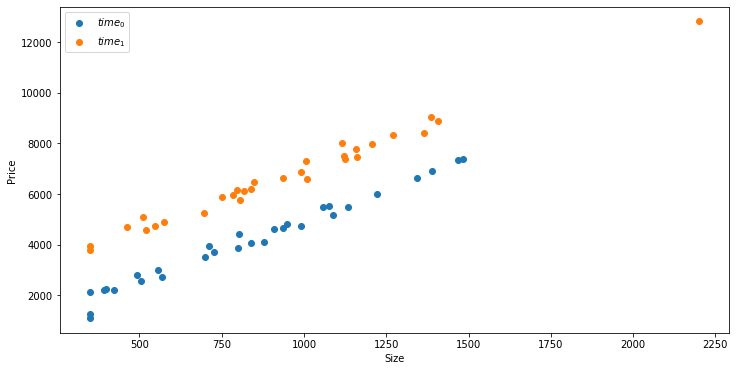

In [9]:
fig_sp

It appears that the data in different groups is similar, but not identical.
- relationship is linear within group
- same "slope" in both groups
- different per-group intercept

Once we make that observation
- We might be tempted to fit a *separate model* for each group.  This is not a great idea
    - Which model do we use for an out of sample example ?
    - The "goodness of fit" increases with sample size

But: how do we even **discover** the presence of two groups
- I added the colors for illustration
- In practice:
    - you are given a large dataset as a "cloud" of mixed examples
    - it might be up to **you** to discover that the single "cloud" of points represents two groups

There are multiple opportunities for a Data Scientist following the Recipe to uncover this
- Exploratory data analysis
    - slicing the data reveals different distributions
- Error Analysis
    - fitting a single line to all examples: the sign of the errors differs by group
    


**Example: Pooling over markets**

Another reason for the presence of more than one group 
- differences in market/geography.

Consider the plot

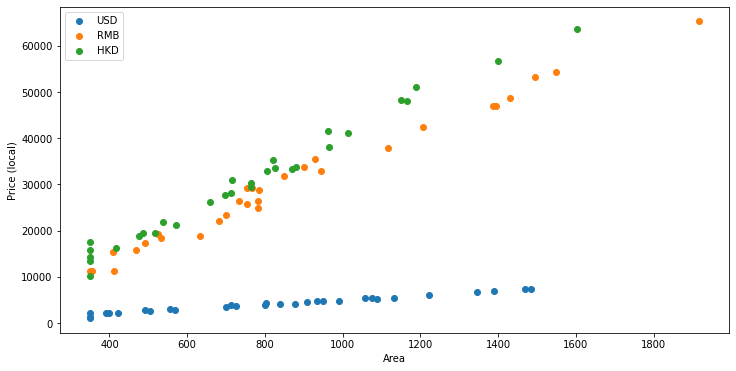

In [10]:
fig_rp

Again
- I have added the colors
- More typically: you have a cloud of points without any clear group distinction

Once you recognize the presence of multiple groups
- what can you do in this case ?

Each group seems to have a linear relationship between Price and Size.

Unlike the prior instance
- each group seems to have its own slope and intercept

Even though each group seems different **on the surface**
- there may be a *single* relationship between targets and features
- that is the *same* across groups
- at a **deeper** level

(We will reveal this common relationship after some time)

# Case study: Making Equity volume more homogeneous and more predictive 

It might be reasonable to hypothesize that
- the daily trading volume (or changes in volume) of an equity is a useful feature
- for predicting stock behavior
- stocks with high volume *appear* to be more liquid
- jumps in volume may be a signal

But
- how should we measure the Volume of a ticker ?

We motivate several transformations of the raw feature (volume measured in Shares).

We use plots from this [notebook](NVDA_normalization.ipynb)
- using NVDA to discuss alternative measure
- comparing the first half of NVDA's historical volume to the second half

## Example: equity trading volume (shares)


The obvious unit of measurement is "number of shares".

In this section, we show why this *may not* be the best measure.

Let us compare the distribution of shares over the two half time periods.

**See the chart [Volume (shares) distributions](NVDA_normalization.ipynb#Volume-(shares)-distributions)**

We can clearly see that the distributions of each half are not the same.

This may prevent us from *pooling volume data over time*
- violates the Fundamental Assumption of Machine Learning


**Moreover**: this measure may not have *good predictive value* as a trading signal.

- when market volume is high
    - the volume of all tickers is high
- we may not discover a signal *solely* related to the ticker
   
Thus, an unusually high volume as measured in "number of shares" may not be a valid trading signal.

## Example: equity trading volume (Dollar volume)

Another common measure of Volume is converting 
- into units of "Dollar Volume*

$$
\text{Dollar Volume} = \text{Volume} * \text{Price}
$$

Often: this is used as a threshold to limit which Tickers to pool
- include a ticker only if it's Dollar Volume each day is "significant"

Let us compare the distribution of shares over the two half time periods.

**See the chart [Volume (dollars) distributions](NVDA_normalization.ipynb#Volume-(dollars)-distributions)**

We can clearly see that the distributions of each half are not the same.

This may prevent us from *pooling volume data over time*
- violates the Fundamental Assumption of Machine Learning


**Moreover**: this measure may not have *good predictive value* as a trading signal.

Even if share volume is constant over time
- the price level varies
- and hence, so does dollar volume

**See chart [Price-distributions](NVDA_normalization.ipynb#Price-distributions)**
   
Thus, an unusually high volume as measured in "number of shares" may not be a valid trading signal.

## Example: equity trading volume (relative to available shares)

Another re-denomination is possible
- into units "fraction of ticker's tradable shares"

That is: what *fraction* of the ticker's available shares has traded.

$$
\text{fraction volume}_j = \frac{\text{volume}_j}{\text{shares outstanding}_j}{}
$$

This re-denomination might allow us to pool across two nearly-identical tickers
- same Market Cap
- but one with
    - twice the number of shares
        - and hence: likely twice the Volume when denominated in units of "number of shares"
    - but half the Price
       

This transformation of units also works for a single ticker
- that has had a Stock Split
    - doubling shares but halving price
- we can now pool across time

Again
- a Transformation into different units
- has allowed us to increase the number of training examples
- by pooling across multiple tickers
- without introducing heterogeneity

We have not created a chart for this measurel

## Example: equity trading volume (Relative to market)

By re-denominating the ticker's Volume 
- into units "fraction of total market volume"
$$
\text{relative volume}_j = \frac{\text{volume}_j}{\sum_{j' \in \mathbb{U}} \text{volume}_{j'}}
$$

we remove the effect of changes in ticker volume
- solely related to changes in Market volume
- solely related to the Price level of the equity

So the objection to the lack of predictive value
- due to factors *external* to the equity

are (partially) addressed.

And, the distributions of the first and second half of history are more similar.

**See chart [Volume-(relative-to-market)-distributions)](NVDA_normalization.ipynb#Volume-(relative-to-market)-distributions)**

Perhaps this is the synthetic feature to use for our goal of creating a trading signal.


# Becoming a successful Data Scientist

The examples in this notebook illustrate the challenges that a Data Scientist encounters.

What distinguishes an "good" Data Scientist from a "great" one is the knowledge and skill to
recognize and circumvent the challenges.

**A key skill of a Data Scientist** is the ability
- to strip away surface differences and reveal underlying commonality between groups
- being able to adapt models to deal with multiple groups

You can *recognize* the challenge
- before starting: by superior Exploratory Data Analysis
- after staring: by superior Error Analysis

Once you recognize the challenges, you may be able to *circumvent* them by
- Transforming the data
    - imposing homogeneity
    - adding features that distinguish between groups
- Find the correct functional form for the model
    - linear
    - polynomial
    - something new

## The world before Black Scholes option pricing

The relationships between targets and features we have explored have usually been simple.

In the real world: the relationships are complex
- missing features
- interaction between features
- described by a new "theory" that is validated by data


Consider the goal of predicting the price of a call option from features of the option.

In the days before the Black Scholes pricing formula was discovered
- people proposed (partially successful) functional forms relating price to features
    - traders carried around tables of approximate prices
    - based on models that partially/conditionally explained prices

Even without a perfect model, an imaginative Data Scientist can come up with partially successful models
with high utility.

A Data Scientist needs
- intuition
- imagination
- scientific rigor and the will to experiment

in order to be able to postulate/test theories relating target to features.

A couple of observations on the Black Scholes call price formula

$$
C = \mathcal{N}(d_1) S_t + - \mathcal{N}(d_2)K * e^{- r*t }
$$
where
$$
\begin{array} \\
d_1 & = & \frac{ \log_e (\frac{S_t}{K}) + (r + .5*\sigma^2)*t
               }
               {
               \sigma * \sqrt{t}
               } 
               \\
d_2 & = & d_1 - \sigma * \sqrt{t}
\end{array}
$$

Notice some interesting "transformed features" in the $d_1$ term
- Price is denominated relative to the strike : $\frac{S_t}{K}$
- Volatility is scaled by time to maturity $t$: $\sigma * \sqrt{t}$

These non-obvious features derive, perhaps, from a need to "normalize" the feature.

# Wrap-up

Obviously, these examples were contrived and overly simple.

In practice, more complex transformations are necessary to make groups more homogeneous.

The insight of the Data Scientist is key in guiding the process.

We will show transformations that address each of these examples (and more) in a separate module.

In [11]:
print("Done")

Done
